# Title: Seed Count-data analysis of groundtruth data and SAM-generated feature extraction data
Author: Harpreet Kaur Bargota
Email: harpreet.bargota@agr.gc.ca
Date: May 9, 2025

In [1]:
# import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.stats.api import DescrStatsW
from scipy.stats import linregress
warnings.filterwarnings(action='ignore')


## Read the output files

### SAM2.1-generated data

In [2]:
# read the .csv file containing the seed count data 
seed2=pd.read_excel(r"ouput_FE_SAM2.1\Seed Count.xlsx")



In [3]:
# check the dataset
print (seed2.head(4))

                    Class  Seed Count
0  Faba-Seed-CC_Vf196-1-2          11
1  Faba-Seed-CC_Vf127-1-2          11
2  Faba-Seed-CC_Vf299-3-1          10
3  Faba-Seed-CC_Vf295-1-1          10


In [4]:
#check teh data

print (seed2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Class       554 non-null    object
 1   Seed Count  554 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.8+ KB
None


In [5]:
#check for descriptive summary of data

print (seed2.describe())

       Seed Count
count  554.000000
mean     7.642599
std      2.701963
min      1.000000
25%      5.000000
50%      9.000000
75%     10.000000
max     11.000000


### Comparison of seed count of groundtruth data with SAM2.1

In [6]:
# read the groundtruth data (Aug data) provided by Dr. Nicholas Larkan 
Aug_data = pd.read_excel("Faba_Seed_Analyzer_Data_August_2024.xlsx", sheet_name="Mean S2 Seed Data")
Aug_data.head(5)

,ID,Main Seed,Main Seeds,Weight(g),TGW(g),Seeds/kg,"""B-Stocking""/Non-Seeds",Date,Time,ØArea,...,Max Width,Max Length,Volume(ml),Volume Weight(kg/hl),ØCircularity,Min Circularity,Max Circularity,ØL/W Ratio,Min L/W Ratio,Max L/W Ratio
0,Vf1-1-2,Vicia faba,4,4.8877,1221.925000,818.380834,8,13/06/2023,14:38,219.500247,...,14.532204,21.097440,15,32.584667,1.168153,1.162423,1.173740,1.368314,1.291562,1.451772
1,Vf4-1-1,Vicia faba,6,1.9316,321.933333,3106.233175,7,13/06/2023,14:40,54.012175,...,8.224431,10.592581,15,12.877333,1.145160,1.126615,1.155499,1.238091,1.169780,1.294690
2,Vf7-1-1,Vicia faba,10,3.5681,356.810000,2802.612034,9,13/06/2023,14:42,65.235907,...,8.462456,11.367768,15,23.787333,1.164687,1.135995,1.187734,1.351447,1.251236,1.429181
3,Vf8-1-1,Vicia faba,9,3.8984,433.155556,2308.639442,9,13/06/2023,14:43,70.955747,...,9.208415,12.489041,15,25.989333,1.161806,1.151720,1.179324,1.317772,1.249530,1.399287
4,Vf9-1-1,Vicia faba,10,4.5645,456.450000,2190.820462,11,13/06/2023,14:45,77.492095,...,9.354255,13.390670,15,30.430000,1.194822,1.167892,1.263545,1.460535,1.374786,1.620578


#### The groundtruth Aug datasheet contains the columns-ID and Main seeds, which gives the information about class ID and number of seeds in images, respectively.

In [7]:
# Extract the df containing only ID, MAin seeds
col_list = ['ID', 'Main Seeds']
Org_Seeds = Aug_data[col_list]
Org_Seeds.head(2)

,ID,Main Seeds
0,Vf1-1-2,4
1,Vf4-1-1,6


#### For uniformity in indices, add the string'Faba-Seed-CC_' before the ID.



In [8]:
# add the string before the string- ID
Org_Seeds['ID'] = 'Faba-Seed-CC_' + Org_Seeds['ID']
Org_Seeds.head(4)

,ID,Main Seeds
0,Faba-Seed-CC_Vf1-1-2,4
1,Faba-Seed-CC_Vf4-1-1,6
2,Faba-Seed-CC_Vf7-1-1,10
3,Faba-Seed-CC_Vf8-1-1,9


#### Join the dfs-seed1 (SAM1 data) and groundtruth data using merge function, which joins both dfs according to the common key "CLass", "ID".

In [9]:
# merge both dfs
merged_df = pd.merge(seed2, Org_Seeds, left_on='Class', right_on='ID', how='inner')
merged_df.head(4)

,Class,Seed Count,ID,Main Seeds
0,Faba-Seed-CC_Vf196-1-2,11,Faba-Seed-CC_Vf196-1-2,11
1,Faba-Seed-CC_Vf127-1-2,11,Faba-Seed-CC_Vf127-1-2,11
2,Faba-Seed-CC_Vf299-3-1,10,Faba-Seed-CC_Vf299-3-1,10
3,Faba-Seed-CC_Vf295-1-1,10,Faba-Seed-CC_Vf295-1-1,10


### Comparitive analysis

#### Regression analysis

In [10]:
# Function to plot regression with stats
def plot_regression_with_stats(df, x_col, y_col):
    x = df[x_col]
    y = df[y_col]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    plt.figure(figsize=(8, 5))
    sns.regplot(x=x, y=y, ci=95, line_kws={'color': 'red'})

    stats_text = (f"Slope = {slope:.2f}\n"
                  f"Intercept = {intercept:.2f}\n"
                  f"R² = {r_value**2:.3f}\n"
                  f"95% CI Shaded")

    plt.title(f"Regression of {y_col} on {x_col}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.text(0.05, 0.95, stats_text,
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.4", fc="lightyellow", ec="black", lw=1))

    plt.grid(True)
    plt.tight_layout()
    plt.show()


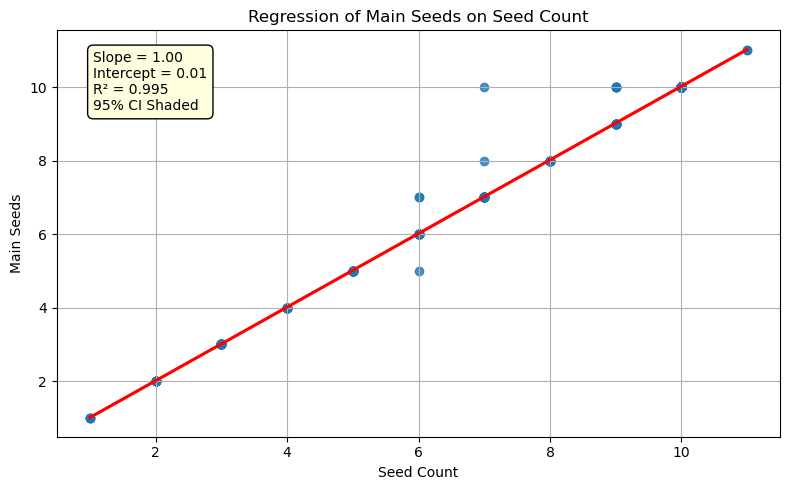

In [11]:

plot_regression_with_stats(merged_df, 'Seed Count', 'Main Seeds')

The results demonstrated a strong correlation between the seed counts by two methods, with a coefficient of determination (R²) of 0.995, indicating an excellent fit. The regression line had a slope of 1.00 and an intercept of 1.00, suggesting a near-perfect linear relationship and minimal systematic bias between the measurements obtained from the two methods.

#### Effect size

In [12]:
def effect_size(df, columns):
        for i in columns:
            col1, col2 = columns[0], columns[1] 
            mean_t1, mean_t2 = df[col1].mean(), df[col2].mean()
            std_t1, std_t2 = df[col1].std(ddof=1), df[col2].std(ddof=1)
            n_t1, n_t2 = len(df[col1]), len(df[col2])

# Compute pooled standard deviation
            s_pooled = np.sqrt(((n_t1 - 1) * std_t1**2 + (n_t2 - 1) * std_t2**2) / (n_t1 + n_t2 - 2))

# Compute Cohen's d
            cohens_d = (mean_t1 - mean_t2) / s_pooled

        print(f"The Cohen's d for {col1} and {col2}: {cohens_d:.3f} ")
        
        
# Interpretation based on effect size
        if abs(cohens_d) < 0.2:
            effect_size = "Small (negligible)"
        elif abs(cohens_d) < 0.5:
            effect_size = "Small to Medium"
        elif abs(cohens_d) < 0.8:
            effect_size = "Medium"
        else:
            effect_size = "Large"

        print(f"Effect Size Interpretation for {col1} and {col2}: {effect_size}")

In [13]:
effect_size(merged_df, ["Seed Count", "Main Seeds"]) 

The Cohen's d for Seed Count and Main Seeds: -0.008 
Effect Size Interpretation for Seed Count and Main Seeds: Small (negligible)


Cohen’s d for the difference between Seed Count and Main Seeds was calculated as -0.008, indicating a negligible effect size. According to standard interpretation guidelines, this suggests minimal variation between the two groups, with no meaningful practical significance.

#### Bland-Altman plot analysis

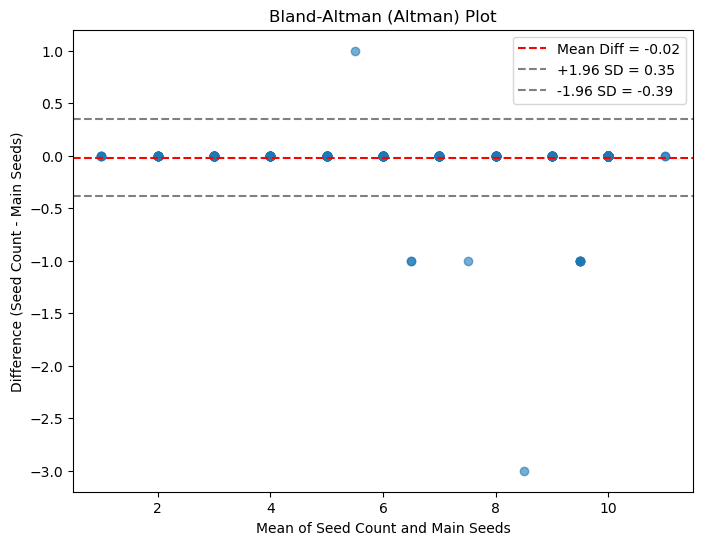

In [14]:
# Compute mean and difference
merged_df['mean'] = merged_df[['Seed Count', 'Main Seeds']].mean(axis=1)
merged_df['diff'] = merged_df['Seed Count'] - merged_df['Main Seeds']

# Mean and limits of agreement
mean_diff = merged_df['diff'].mean()
std_diff = merged_df['diff'].std()
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

# Plot
plt.figure(figsize=(8,6))
plt.scatter(merged_df['mean'], merged_df['diff'], alpha=0.6)
plt.axhline(mean_diff, color='red', linestyle='--', label=f'Mean Diff = {mean_diff:.2f}')
plt.axhline(loa_upper, color='gray', linestyle='--', label=f'+1.96 SD = {loa_upper:.2f}')
plt.axhline(loa_lower, color='gray', linestyle='--', label=f'-1.96 SD = {loa_lower:.2f}')

plt.xlabel('Mean of Seed Count and Main Seeds')
plt.ylabel('Difference (Seed Count - Main Seeds)')
plt.legend()
plt.title('Bland-Altman (Altman) Plot')
plt.show()


The Bland-Altman plot was used to assess the agreement between the Seed Count and Main Seeds measurements. The mean difference between the two methods was -0.02, indicating a very small bias. Most of the data points fall within these limits, suggesting good agreement between the two measurements. However, a few outliers are observed below the lower limit.
Overall, the plot indicates that the Seed Count and Main Seeds methods are largely consistent, with minimal systematic bias.

Since the merged_df has the data for number of seeds in groundtruth data and SAM measured data. Lets see if both the data are equal by subtracting the number of seeds from each other. if the value is zero, it means the number of seeds are the same in groundtruth data and the SAM measured data.

In [15]:
#check if seed count is the same
merged_df['Seeds_left'] = merged_df['Seed Count'] - merged_df['Main Seeds']
merged_df.head(4)

,Class,Seed Count,ID,Main Seeds,mean,diff,Seeds_left
0,Faba-Seed-CC_Vf196-1-2,11,Faba-Seed-CC_Vf196-1-2,11,11.0,0,0
1,Faba-Seed-CC_Vf127-1-2,11,Faba-Seed-CC_Vf127-1-2,11,11.0,0,0
2,Faba-Seed-CC_Vf299-3-1,10,Faba-Seed-CC_Vf299-3-1,10,10.0,0,0
3,Faba-Seed-CC_Vf295-1-1,10,Faba-Seed-CC_Vf295-1-1,10,10.0,0,0


check for the class ID with unequal number of seeds.

In [16]:
# check for the ID with unequal seed count
filtered_df = merged_df[merged_df['Seeds_left'] != 0]
filtered_df

,Class,Seed Count,ID,Main Seeds,mean,diff,Seeds_left
262,Faba-Seed-CC_Vf460-1-1,9,Faba-Seed-CC_Vf460-1-1,10,9.5,-1,-1
263,Faba-Seed-CC_Vf456-1-1,9,Faba-Seed-CC_Vf456-1-1,10,9.5,-1,-1
265,Faba-Seed-CC_Vf620-1-1,9,Faba-Seed-CC_Vf620-1-1,10,9.5,-1,-1
266,Faba-Seed-CC_Vf619-1-1,9,Faba-Seed-CC_Vf619-1-1,10,9.5,-1,-1
274,Faba-Seed-CC_Vf117-1-2,9,Faba-Seed-CC_Vf117-1-2,10,9.5,-1,-1
276,Faba-Seed-CC_Vf198-1-2,9,Faba-Seed-CC_Vf198-1-2,10,9.5,-1,-1
336,Faba-Seed-CC_Vf280-1-2,7,Faba-Seed-CC_Vf280-1-2,8,7.5,-1,-1
345,Faba-Seed-CC_Vf615-1-1,7,Faba-Seed-CC_Vf615-1-1,10,8.5,-3,-3
357,Faba-Seed-CC_Vf90-1-1,6,Faba-Seed-CC_Vf90-1-1,7,6.5,-1,-1
360,Faba-Seed-CC_Vf139-1-1,6,Faba-Seed-CC_Vf139-1-1,5,5.5,1,1


### Success rate (%) for seed count for SAM2.1 generated data
The performance of the pipeline was evaluated based on its success rate, defined as the percentage of images where the predicted image count matched the ground truth. 
The success rate was calculated using the formula:
Success Rate (%) = (Number of images with correct seed count with groundtruth / Total number of images) × 100.
This metric reflects the pipeline’s ability to produce accurate count predictions in comparison to the annotated ground truth.



In [17]:
print ("Number of images with correct seed count with groundtruth: ",len(seed2)-len(filtered_df))
print ("Total number of images in groundtruth data= ", len(seed2))
print ("Number of images with incorrect number of seeds= ", len(filtered_df))

Number of images with correct seed count with groundtruth:  543
Total number of images in groundtruth data=  554
Number of images with incorrect number of seeds=  11


In [18]:
Success_rate=100*((len(seed2)-len(filtered_df))/len(seed2))
Success_rate     
print (f"The faba bean feature extraction pipeline leveraging SAM2.1 has {Success_rate}% success rate.")
              

The faba bean feature extraction pipeline leveraging SAM2.1 has 98.014440433213% success rate.


### Results: Pipeline with SAM2.1: 
The pipeline is  98 % successful in extracting the phenotypic traits from faba bean images.

Detailed analysis from images with incorrect number of seeds generated from SAM2.1 data:
1. Errors in  images -- Vf460, Vf117, Vf198, Vf619, Vf283, Vf90- no masks for 1 seed and Vf615 (no masks for 3 seeds). 
2. Vf456 and Vf280 has bounding box coords for bbox w greater than 700. 
3. Vf139-small nonspecific part detected.
4. Error in Vf620: Incorrect number of seeds in Aug data (originally 9 in image but incorrectly written as 10 in Aug data in excel.


#### Pipeline with SAM: Errors in 7 images (Vf615, Vf117, Vf11, Vf460, Vf619, Vf283, Vf90) due to mask not formed for 1 seed. Error in Vf620: Incorrect number of seeds in Aug data (originally 9 in image but incorrectly written as 10 in Aug data in excel. These errors can be reduced by finetuning SAM using difefrent parameters.


## Conclusion: Overall, the plots indicates that the SAM-generated method for feature extraction and groundtruth data methods are largely consistent, with minimal systematic bias.